# [Demo] Bayesian filters: follow rotations

Wouter Kouw | Last update: 17-08-2023
 

## System

Consider a discrete-time dynamical system with noisy observations $y_k \in \mathbb{R}^{d_y}$ and latent states $x_k \in \mathbb{R}^{d_x}$. We can express the dynamics in the form of a state-space model:

$$\begin{align}
x_k =&\ Ax_{k-1} + q_{k-1} \\
y_k =&\ Cx_k + r_{k} \, ,
\end{align}$$

where $A$ is a state transition matrix, $C$ is an observation emission matrix, $q_{k-1}$ represents process noise and $r_{k}$ is measurement noise. Both sources of noise are Gaussian distributed with zero mean:

$$q_{k-1} \sim \mathcal{N}(0, I) \, , \qquad r_k \sim \mathcal{N}(0, R) \, ,$$

with covariance matrices $I$ and $R$.

The state transition has the following form:

$$\begin{align*}
\underbrace{\begin{bmatrix} x_{1,k} \\ x_{2,k} \\ x_{3,k} \\ x_{4,k} \end{bmatrix}}_{x_k} = \underbrace{\begin{bmatrix} \cos(\omega) & -\sin(\omega) & 0 & 0 \\ \sin(\omega) & \cos(\omega) & 0 & 0 \\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 0\end{bmatrix}}_{A} \underbrace{\begin{bmatrix} x_{1,k-1} \\ x_{2,k-1} \\ x_{3,k-1} \\ x_{4,k-1} \end{bmatrix}}_{x_{k-1}} + q_{k-1}
\end{align*}$$

where $\omega$ represents the angle.

The measurement function is described as:

$$\begin{align*}
\underbrace{\begin{bmatrix} y_{1,k} \\ y_{2,k} \\ y_{3,k} \\ y_{4,k} \end{bmatrix}}_{y_k} = \underbrace{\begin{bmatrix} 1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1 \end{bmatrix}}_{C} \begin{bmatrix} x_{1,k} \\ x_{2,k} \\ x_{3,k} \\ x_{4,k} \end{bmatrix} + r_k
\end{align*}$$

The observations are noisy representations of the four latent states.

#### Generate data

In [1]:
using LinearAlgebra
using Distributions
using ProgressMeter
using Plots
default(label="", grid=false, margin=20Plots.pt)

In [2]:
include("../variational_filters.jl")

adaptive_transition (generic function with 1 method)

In [3]:
# Length of time-series
T = 100
Δt = 1.0

# Dimensionalities
D = 4

# Transition matrix
ω = 0.3
A = [cos(ω) -sin(ω) 0 0;
     sin(ω)  cos(ω) 0 0;
       0       0    1 0;
       0       0    0 0]

# Emission matrix
C = diagm(ones(4));
    
# Measurement noise variance  
σ = 0.1
R = σ^2 .*Matrix{Float64}(I,4,4)
     
# Initial states
state_0 = zeros(4)

# Initialize data array
states = zeros(D,T)
observations = zeros(D,T)

# Initialize previous state variable
prev_state = state_0

for k = 1:T
    
    # State transition
    states[:,k] = A*prev_state + randn(D)
    
    # Observation with added measurement noise
    observations[:,k] = C*states[:,k] + cholesky(R).L*randn(D)
    
    # Update "previous state"
    prev_state = states[:,k]
    
end    

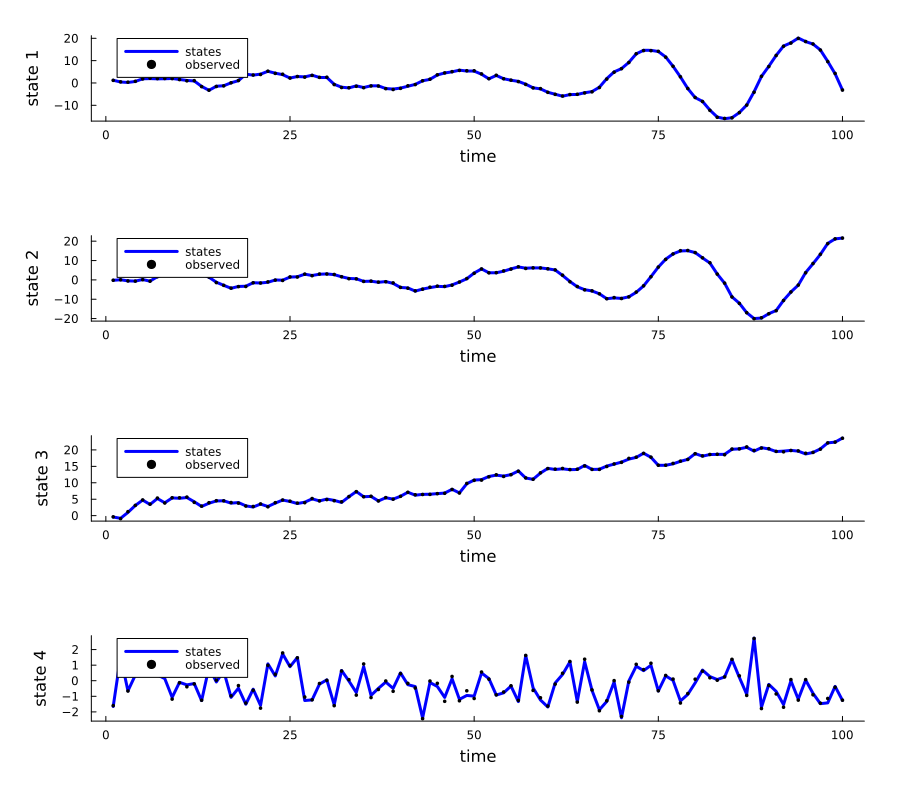

In [4]:
plts = []
for d = 1:D
    plt_d = plot((1:T).*Δt, states[d,:], linewidth=3, color="blue", xlabel="time", ylabel="state $d", label="states", size=(700,400))
    scatter!((1:T).*Δt, observations[d,:], color="black", markersize=2, label="observed", legend=:topleft)

    push!(plts, plt_d)
end
plot(plts..., layout=(D,1), size=(900,D*200))

In [5]:
# Relevance prior
α0 = [1.0, 1.0, 0.1, 0.1]
β0 = [1.0, 1.0, 1.0, 1.0]
γ0 = [Gamma(α0[d], β0[d]) for d in 1:D]

# State prior
m0 = zeros(D)
S0 = diagm(ones(D))

# Kalman filter
mx, Px, μ,Σ,α,β = adaptive_transition([observations[:,k] for k in 1:T], Q, C, R, γ0, MvNormal(m0,S0), num_iters=10);

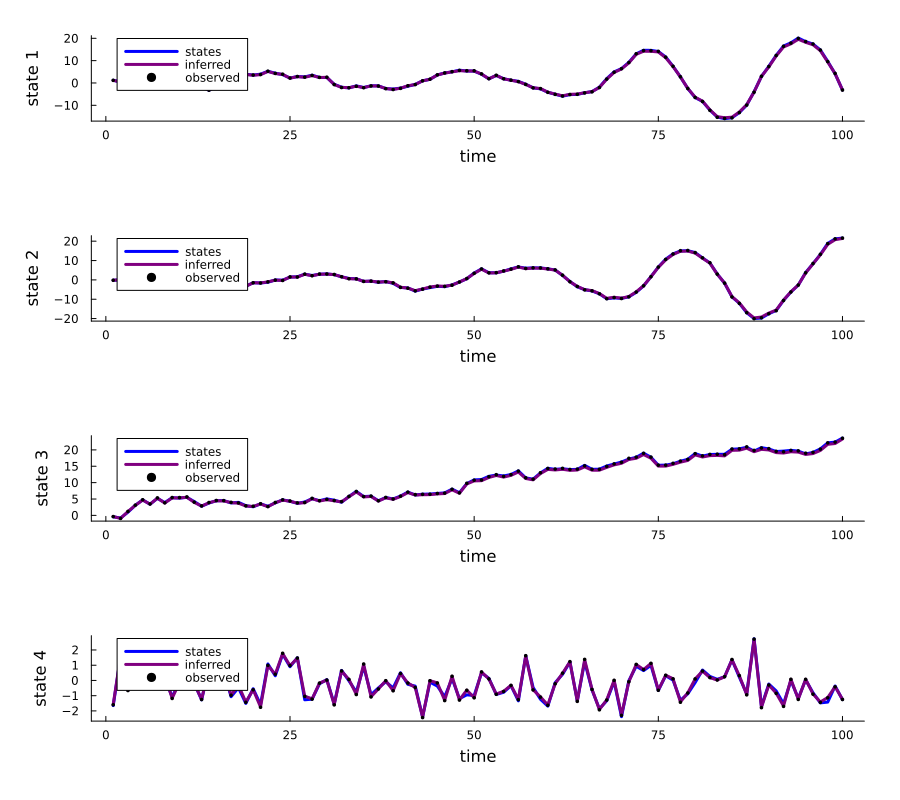

In [6]:
plts = []
for d = 1:D
    plt_d = plot(size=(700,400),legend=:topleft)
    plot!((1:T).*Δt, states[d,:], linewidth=3, color="blue", xlabel="time", ylabel="state $d", label="states")
    plot!((1:T).*Δt, mx[d,:], ribbon=sqrt.(Px[d,d,:]), linewidth=3, color="purple", label="inferred")
    scatter!((1:T).*Δt, observations[d,:], color="black", markersize=2, label="observed")

    push!(plts, plt_d)
end
plot(plts..., layout=(D,1), size=(900,D*200))

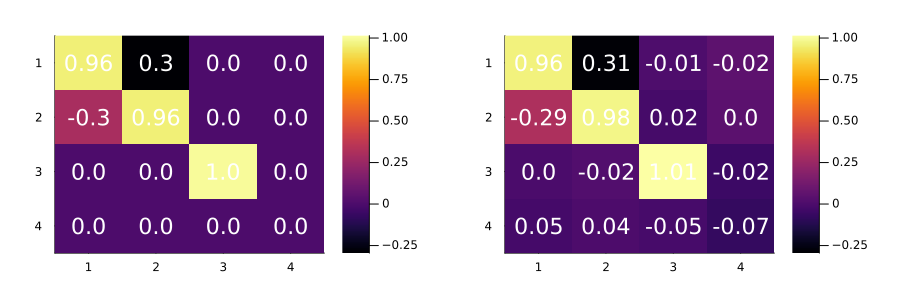

In [7]:
cmins = minimum([minimum(A[:]), minimum(μ[:])])
cmaxs = maximum([maximum(A[:]), maximum(μ[:])])

fontsize=15

# Plot inferred state transition matrix
p21 = heatmap(A, yflip=true, clims=(cmins,cmaxs))
ann = [(i,j, text(round(A[i,j], digits=2), fontsize, :white, :center)) for i in 1:D for j in 1:D]
annotate!(ann, linecolor=:white)

p22 = heatmap(μ, yflip=true, clims=(cmins,cmaxs))
ann = [(i,j, text(round(μ[i,j], digits=2), fontsize, :white, :center)) for i in 1:D for j in 1:D]
annotate!(ann, linecolor=:white)

plot(p21,p22, layout=(1,2), size=(900,300))

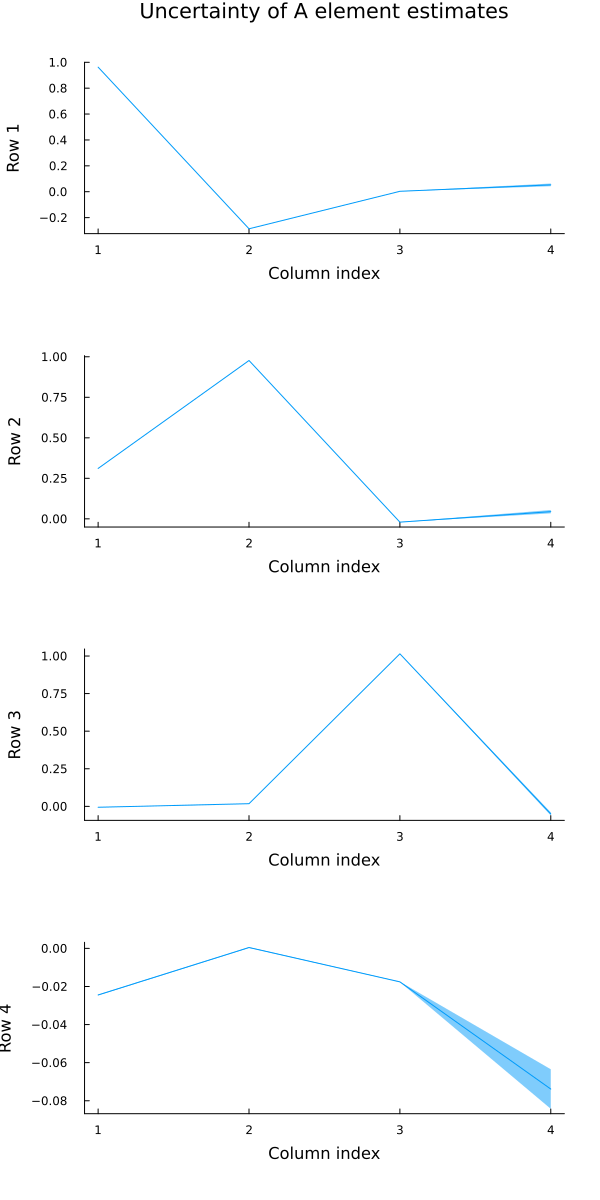

In [8]:
plt_1 = plot(μ[1,:], ribbon=diag(Σ[:,:,1]), ylabel="Row 1", xlabel="Column index", title="Uncertainty of A element estimates")
plts = [plt_1]

for d in 2:D
    plt_d = plot(μ[d,:], ribbon=diag(Σ[:,:,d]), ylabel="Row $d", xlabel="Column index")
    push!(plts, plt_d)
end
plot(plts..., layout=(D,1), size=(600,D*300))